# Hotel reviews classification using Arabic ULMFIT model
### You can get this dataset from https://github.com/elnagara/HARD-Arabic-Dataset .
This dataset contains 93700 hotel reviews in Arabic language. The hotel reviews were collected from Booking.com website during June/July 2016. The reviews are expressed in Modern Standard Arabic as well as dialectal Arabic. 
##### *Citation*:
> Elnagar A., Khalifa Y.S., Einea A. (2018) Hotel Arabic-Reviews Dataset Construction for Sentiment Analysis Applications. 
In: Shaalan K., Hassanien A., Tolba F. (eds) Intelligent Natural Language Processing: Trends and Applications. 
Studies in Computational Intelligence, vol 740, pp: 35-52. Springer International Publishing. 
doi="10.1007/978-3-319-67056-0_3. url="https://doi.org/10.1007/978-3-319-67056-0_3"

For more information about ULMFIT see [Paper](https://arxiv.org/abs/1801.06146) & [Blog post](http://nlp.fast.ai/).

### Using our pretrained Arabic ULMFIT language model we do the following:
1- Preprocess our dataset and get it ready for use in the coming steps by creating a language model databunch & classifer databunch.

2- Load our language model with pretrained weights then fine-tune it to our dataset.

3- Create a classifier on top of the encoder of the language model.

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.text import *
import path
import copy

In [4]:
#Latest dev version of fastai in order to get some fixes for QRNNs
import fastai; fastai.__version__

'1.0.51.dev0'

In [80]:
data_path = Path('data')
lm_path = Path('.')

### 1- Pre-processing our Dataset :

**This notebook uses the unbalanced reviews file (13% neg, 19% ntl, 68% pos),  you can find the notebook that uses the balanced reviews in the same github repo.**

In [5]:
unbalanced_df = pd.read_csv(data_path/'unbalanced-reviews.txt',delimiter='\t',encoding='utf_16_le')

In [6]:
unbalanced_df.head()

,no,Hotel name,rating,user type,room type,nights,review
0,1,فندق 72,4,زوج,غرفة قياسية مزدوجة,أقمت ليلة واحدة,“فندق راقي وسوف تتكرر زيارتي له”. الفندق بصراح...
1,2,فندق 72,2,مسافر منفرد,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلة واحدة,“ممتاز”. النظافة والطاقم متعاون.
2,3,فندق 72,5,زوج,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلة واحدة,استثنائي. سهولة إنهاء المعاملة في الاستقبال. ل...
3,4,فندق 72,4,زوج,غرفة قياسية مزدوجة,أقمت ليلة واحدة,جيد جداً. 😊👍. لايوجد
4,5,فندق 72,5,زوج,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلة واحدة,“الحمدلله رب العالمين كان يوم جميل قضيناه في ا...


In [7]:
unbalanced_df.shape

(409562, 7)

*Create A held-out test dataset using 10% of our full dataset. and drop it from the full dataset.*

In [8]:
test_df = unbalanced_df.sample(frac = .1 ,replace=False,random_state = 42)

In [9]:
unbalanced_df = unbalanced_df.drop(test_df.index)
unbalanced_df.shape

(368606, 7)

*Create 2 csv files containing our train/valid and our test datasets.*

In [11]:
test_df.to_csv(data_path/'unbalanced_reviews_test.csv',index=False)

In [12]:
unbalanced_df.to_csv(data_path/'unbalanced_reviews_train.csv',index=False)

In [82]:
unbalanced_train_df = pd.read_csv(data_path/'unbalanced_reviews_train.csv')

In [81]:
unbalanced_test_df = pd.read_csv(data_path/'unbalanced_reviews_test.csv')

* Create a Language model databunch that does all the necessary preprocessing like tokenization and numericalization.

* All the text in the dataset is concatenated and the labels are ignored. Instead, the target is the next word in the sentence.

* We also create a validation set that is 10% of our full dataset (80% train 10% valid 10% test).

In [16]:
reviews_lm_data = (TextList.from_df(unbalanced_train_df,cols=['review'])
                   .split_by_rand_pct(.1)
                   .label_for_lm()
                   .databunch(bs=64))

In [17]:
reviews_lm_data.show_batch()

idx,text
0,جدا انا اعتبره شقق راقيه جدا اكثر من فندق . لاشئ بصراحه الا ملاحظه واحدة اني شاهدة xxunk ( حشرة ) صغيره جدا علي الارض هذي الملاحظة الوحيدة فقط ولا الغرفه عموم نظيفة ولا شفنا فيها اي شي xxbos “ ممتاز ” . النظافة والطاقم متعاون . xxbos استثنائي . سهولة إنهاء المعاملة في الاستقبال . لاشيئ xxbos جيد جداً. 😊 👍 . لايوجد xxbos “ الحمدلله رب العالمين كان
1,xxunk من خارج xxunk إلى أن أدخل xxunk xxunk أنتظر حتى يسألني أحدهم لماذا تريد العربة . كل شيء xxbos “ غير راضي ” . . مكان سيئ وغير نظيف والصورة المعروضة في الموقع غير الواقع xxbos ضعيف جداً. لا شيء . كل شي ، ، تجربة سيئة لن تتكرر xxbos “ جيده جدا ” . . مياه xxunk ساخنه جدا xxbos ضعيف جداً. . عدم تعاملهم بالرد على الاتصالات
2,. النظافة ضعيفة xxbos “ اجازة نهاية الاسبوع في قصر الحمرا ” . * الاطلالة على البحر * الموقع . الغرف الواسعة .. * السجادات الموجودة في الصالة وغرف النوم غير نظيفة . * صنابير المياه ومغاسل الحمامات معطلة . * مفاتيح الابواب الخاصة بالبلكونة غير موجودة ، الباب الخاص بالبلكونة في غرفة النوم معطل . * عدم توفر xxunk في الغرف . * الكواية معطلة . * xxunk كنترول
3,اغلبية الفنادق التى تقدم هذه الخدمة مجانا داخل الغرف وهو الامر الذى تسبب لنا xxunk xxunk xxbos “ هذا الفندق لا يستحق ان يكون خمسة نجوم ” . سعر العرض . رائحة الغرفة من الموكيت . وايضا رائحة المخدات سيئة xxbos مقبول . القرب من الحرموجود xxunk الغرف ممتازفي الاستقبال شاب لطيف جدا اسمه أحمد . مع كبر الفندق والزحمة المصاعد تعتبر قليلةعدم حضور حامل الحقائب واضطررت لحمل الحقائب من
4,فندق ٥ ستار ولايوجد به انترنت مجاني ! ! ! المناشف قديمة جدا ! ! xxbos ممتاز . الراحه تامه ولايوجد ازعاج . الحمام غير مرتب xxbos جيد . القرب من الحرم . تغير المصاعد ولا يوجد عزل صوت بين الغرف xxbos جيد . . عندما حجزت في الصورة كان هناك ٤ اسرة ولكن في الواقع اصبحت ٢ xxbos “ جيد ولكن مبالغ في السعر ” . الهدوء وسهولة الوصول


*Save our databunch so we can load it instantly later if we want.*

In [18]:
reviews_lm_data.save('unbalanced_reviews_lm')

In [19]:
reviews_lm_data = load_data(lm_path,'unbalanced_reviews_lm')

* Create a classification databunch that does all the necessary preprocessing like tokenization and numericalization.
* We map the rating to labels ('pos' , 'neg' or 'ntl').
* We also pass the vocabulary (mapping from ids to words) that we want to use to ensure that our classification databunch will use the same dictionary as our language model databunch.

In [20]:
label_for_reviews = lambda x: 'neg' if(x[1] < 3) else ('pos' if x[1] > 3 else 'ntl')

In [21]:
reviews_cls_data = (TextList.from_df(unbalanced_train_df,cols=['review','rating'],vocab=reviews_lm_data.train_ds.vocab)
                   .split_by_rand_pct(.1)
                   .label_from_func(label_for_reviews)
                   .databunch(bs=64))

In [22]:
reviews_cls_data.show_batch()

text,target
xxbos جيد . كل شي أعجبني ما عدا ان هناك ان المصري اللي أسمه أحمد وقام بأقفال حجوزات البوكينج ووضع الفندق محجوز بالكامل وعندما أردت التجديد ليوم واحد قال لي عن طريق البوكينج وحاولت الحجز عن طريق البوكنج ووجدت أن الفندق محجوز بالكامل ورفضت الخروج وقال لي تدفع زيادة في السعر أكثر من 200 % والا تغادر فرفضت وجلست في الفندق إلى اليوم التالي ولم أجد اي نزلاء جدد وكانت,pos
xxbos “ الشاليهات ممتعة ” . الشاليهات فيها خصوصية جميلة ، منطقة البحر الخاصة بك ، وقربها من الشاليه ، تستطيع رؤية xxunk أثناء xxunk في البحر من صالة الشاليه بكل وضوح .. باحة الشاليه أو التراس واسعة وفيها جلسة خارجية جميلة ، xxunk كبيرة ، وحولك xxunk أضفت للمكان xxunk فيها كل شيء xxunk ماركت ، كوفي ، محل xxunk بالمرافق الممتعة : ألعاب الأطفال ، دراجات ، دبابات,pos
xxbos حسن . الفندق يقع في موقع ممتاز على كورنيش العاصمة الحبيبة أبوظبي . الفندق مصنف من فئة خمس نجوم ولكن للأسف الشديد حصلت لي بعض المواقف ومنها : أثناء وصولي إلى قسم الاستقبال قبل البدء بالحجز سألت الموظف عن نوعية الغرف وكان رده أنه ليس لديه علم xxunk الموضحة في booking وبعدها مباشرة تم الحجز عن طريق الموقع المذكور وبعد الانتهاء منه ذهبت مرة أخرى لموظف الاستقبال لإجراء إجراءات,ntl
xxbos “ اسوأ تجربه في حياتي دتخل المملكة وخارجها ” . لم احب في هذا الفندق الا القرب من الحرم و وجبة الافطار وكان عندهم عرض ع السعر فقططط واحذر الجميع من السكن فيه . عدة امور ضايقتني في هذا الفندق السيء # الدخول للغرفة استغرق اكثر من ساعتين وتفاجئت ان وضعي افضل من غيري xxunk جلس ينتظر اكثر من ذلك # مواقف السيارات ليست مجانية ولم يذكر ذلك في,ntl
xxbos “ جدا متعب خاصة الصعود والنزول للحرم وماكان نظيف مرة .. لن اعود إليه مجددا بالتأكيد ” . لم يكن هناك شي مميز . كنت انا وامي فقط لكن لم اجد مايناسب ذلك من الخيارات السابقة .. يبدو اننا خدعنا بمظهر الفندق فقد كان على طلعة جبل وهذا لم يكن واضح والا لم أكن xxunk هناك خاصة مع وضع امي الصحي فقد xxunk كثيرا xxunk للرسيبشن xxunk xxunk لأصحاب,neg


In [23]:
reviews_cls_data.save('unbalanced_reviews_cls')

In [24]:
reviews_cls_data = load_data(lm_path,'unbalanced_reviews_cls')

## 2- Fine-tune our LM to our Dataset:

In [25]:
pretrained_lm_fname = 'new_lm'
pretrained_itos_fname = 'itos'

* We will create a uni-directional [QRNN] (https://arxiv.org/abs/1611.01576) that will load our pre-trained language model weights stored in `new_lm.pth` and also load  `itos.pkl`  which contains our id to token mapping.
* We also pass it our language model databunch which we will fine-tune our language model to.

In [26]:
emb_sz:int = 400
nh: int = 1550
nl: int = 3

qrnn_config = copy.deepcopy(awd_lstm_lm_config)
dps = dict(output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
qrnn_config.update({'emb_sz':emb_sz, 'n_hid':nh, 'n_layers':nl, 'pad_token':1, 'qrnn':True})
qrnn_config

{'emb_sz': 400,
 'n_hid': 1550,
 'n_layers': 3,
 'pad_token': 1,
 'qrnn': True,
 'bidir': False,
 'output_p': 0.1,
 'hidden_p': 0.15,
 'input_p': 0.25,
 'embed_p': 0.02,
 'weight_p': 0.2,
 'tie_weights': True,
 'out_bias': True}

In [27]:
lm_learner = language_model_learner(reviews_lm_data,AWD_LSTM,pretrained=False,config=qrnn_config, model_dir=lm_path,drop_mult=.3,pretrained_fnames=(pretrained_lm_fname,pretrained_itos_fname))

In [29]:
lm_learner.lr_find(start_lr = slice(10e-7,10e-5),end_lr=slice(0.1,10))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


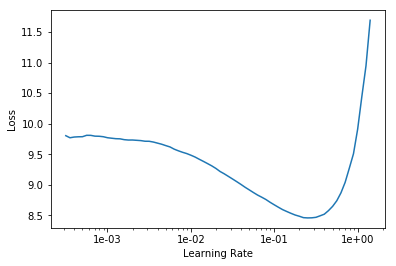

In [30]:
lm_learner.recorder.plot(skip_end=10)

In [31]:
lm_learner.metrics = [accuracy,Perplexity()]

*We train our model starting from the last layer then unfreezing the model and training the entire network*

In [32]:
lm_learner.fit_one_cycle(1,2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.536251,5.103558,0.238418,164.606781,05:38


In [33]:
lm_learner.save('unbalanced-stage1-lm-1epoch')

In [34]:
lm_learner.unfreeze()

In [35]:
lm_learner.fit_one_cycle(2,2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.773859,4.638681,0.267469,103.407898,06:13
1,4.480889,4.409340,0.284175,82.215179,06:13


In [36]:
lm_learner.save('unbalanced-stage2-lm-2epoch')

In [37]:
lm_learner.fit_one_cycle(2,2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.654118,4.549596,0.272579,94.594078,06:13
1,4.380896,4.364487,0.286884,78.609116,06:13


In [39]:
lm_learner.save('unbalanced-stage2-lm-4epoch')

* To evaluate our language model, we run the `Learner.predict` method specifying the number of words we want it to guess.
* We can see that the predicted words don't make much sense but are coherent and follow basic grammer thanks to our language model.

In [44]:
lm_learner.predict('الغرفة جميلة',n_words=10)

'الغرفة جميلة ومريحة ❤ ️ .. والله العظيم اني لا أستطيع تكرار'

*We save the language model encoder to use it for classification in the next step.*

In [46]:
lm_learner.save_encoder('unbalanced-stage2-lm-enc')

### 3- Creating the classifer:

*We now use the classifer databunch we created earlier to build a classifier with our fine-tuned encoder.* 

In [63]:
qrnn_cls_config = copy.deepcopy(awd_lstm_clas_config)
dps = dict(output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
qrnn_cls_config.update({'emb_sz':emb_sz, 'n_hid':nh, 'n_layers':nl, 'pad_token':1, 'qrnn':True})
qrnn_cls_config

{'emb_sz': 400,
 'n_hid': 1550,
 'n_layers': 3,
 'pad_token': 1,
 'qrnn': True,
 'bidir': False,
 'output_p': 0.4,
 'hidden_p': 0.3,
 'input_p': 0.4,
 'embed_p': 0.05,
 'weight_p': 0.5}

In [64]:
clas_learner = text_classifier_learner(reviews_cls_data,AWD_LSTM,config=qrnn_cls_config,model_dir=lm_path,drop_mult=.5)

In [65]:
clas_learner.load_encoder('unbalanced-stage2-lm-enc')

In [66]:
clas_learner.lr_find(start_lr = slice(10e-7,10e-5),end_lr=slice(0.1,10))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


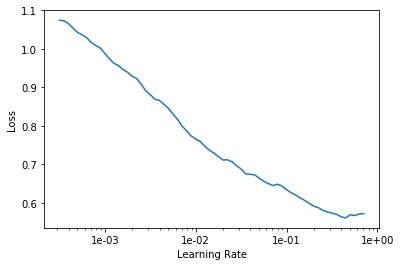

In [67]:
clas_learner.recorder.plot(skip_end=10)

*Again We train our model starting from the last layer then unfreezing the model and training the entire model
we use `F-score` as a metric to compare our results to the cited paper.*

In [68]:
clas_learner.metrics = [accuracy,FBeta(beta=3,average='weighted')]

In [69]:
clas_learner.fit_one_cycle(1,2e-3)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.231702,0.092588,0.968692,0.968566,01:48


In [70]:
clas_learner.save('unbalanced-stage1-1epoch')

In [71]:
clas_learner.unfreeze()

In [72]:
clas_learner.fit_one_cycle(2,2e-3)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.007584,0.000004,1.000000,1.000000,04:40
1,0.001745,0.000000,1.000000,1.000000,04:28


In [73]:
clas_learner.save('unbalanced-stage2-2epoch')

*We can test our classifier by giving it a review and see the predicted sentiment and its propablity.*

In [74]:
text = 'الفندق سيئ'

In [75]:
clas_learner.predict(text)


(Category neg, tensor(0), tensor([0.7053, 0.0032, 0.2915]))

In [76]:
clas_learner.show_results()

text,target,prediction
xxbos “ منتجع ممتاز للإستجمام ” . لدي الكثير xxunk عن هذا المنتجع xxunk إذا xxunk كفندق فهو خمس نجوم بامتياز ولا أدري لما تصنيفه ثلاث نجوم فقط ، xxunk عندما قرأت تعليقات النزلاء xxunk تخوفت كثيراً من كون المنتجع سيء . عندما ذهبت إلى هناك فوجئت بالخدمة الممتازة . _ مواقف السيارات كافية لكل النزلاء فيما أعتقد _ الاستقبال ممتاز ولديه لباقة ويليق بفندق راق _ الممرات والساحات نظيفة,pos,pos
xxbos “ نعم ولكن ” . تم زيارة عائلتي لهذا الفندق أربع مرات سابقاً xxunk الجميع بخدمة ممتازة ومميزة واستقبال رائع وسرعة في اجراءات الدخول أمي تحب هذا الفندق كثيراً ونصحت أخي بالنزول فيه أخي يسكن بالمنطقة الشرقية بناءً على رغبته في تجربة هذا الفندق xxunk حجز الفندق عن طريق بطاقتي الائتمانية لمدة ثلاث تم اقتطاع المبلغ وبما أنني xxunk من سكان المدينه قمت xxunk لضمان الحجز بالاتصال والسؤال عن,neg,neg
xxbos ضعيف جداً. فندق فخم بس إدارة فاشلة و مزعجة و متعبة . 1 ) اتصلت قبل الوصول بساعة و أخبرتهم أنني سأصل فيرجى عدم التأخير مثل كل مرة على الرسبشن و طلبت تجهيز الأوراق للتوقيع و استلام الغرفة حيث أنني حاجز بالأنترنت .. فتفاجأت بتأخيري ساعة كاملة ... xxunk ) لم يرسلوا العربة لنقل الأغراض من الباركن بالسيارة للغرفة فاضطريت لنقل الأغراض بنفسي على دفعتين من الباركن تحت الأرض,neg,neg
xxbos “ جميلة ” . القيمة مقابل المال تعتبر ممتازة جد xxrep 4 ا حيث الخدمات وكثرة الموظفين في منطقة الرسبشن وحوله والابتسامة وتقديم خدمات من فتح باب الفندق وطلب تاكسي xxunk عربية البيبي فالسيارة بمجرد طلب اي شي سواء بالتلفون او من خلال الموظف مباشرة ، لا اجامل والله ولا اكذب ، لن تصل غرفتك الا وقد تحقق ماتريد ، والله فعلا هناك سرعة xxunk xxunk اغلب الفنادق ..,pos,pos
xxbos مرضي . الهدوء . عندما اقمنا لديهم في يومي الخميس والجمعه 14 - 16 / 2014 / 8 في هذا الجناح 216 والذي xxunk بالجناح xxunk الذي جعلوني اقيم فيه رغماً عني مع العلم انني حجزت عبر موقعكم جناح تنفيذي اكبر مساحه xxunk متر واعطوني جناح تنفيذي xxunk مساحه وعندما سألتهم عن اسباب ذلك تعذروا بانني حجزت متاخر عند الثانيه من ظهر نفس اليوم ولايوجد الجناح الذي حجزته والسؤال,ntl,ntl


*We create a temp databunch containg our held-out test dataset to validate our classifer.*

In [77]:
unbalanced_all_df = pd.concat([unbalanced_train_df,unbalanced_test_df])
unbalanced_all_df.shape

(409562, 7)

In [78]:
reviews_cls_test_data = (TextList.from_df(unbalanced_all_df,cols=['review','rating'],vocab=reviews_lm_data.train_ds.vocab)
                   .split_by_idx(unbalanced_test_df.index)
                   .label_from_func(label_for_reviews)
                   .databunch(bs=64))

In [79]:
#Validate returns (error rate , accuracy , F-Score)
clas_learner.validate(reviews_cls_test_data.valid_dl)

[5.5179265e-07, tensor(1.), tensor(1.)]